# Austin Bikeshare Analysis
### Presented by: Bladimir Nunez
### Updated: May 6, 2024
### Project Goals:
1. Analyze bike trip durations to understand average trip lengths and peak usage times.
2. Identify popular start and end stations to optimize bike distribution and station maintenance.
3. Explore subscriber types to understand user demographics and preferences.
4. Visualize bike usage trends over time to identify seasonal variations.

## Import Libaries

In [1]:
pip install google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install google-auth

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install google-auth-oauthlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install db-dtypes

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
import numpy as np
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/bladimirnunez/Desktop/service-account.json"
pd.set_option('display.max_rows', None)

## Data Gathering

In [6]:
# Create a client to connect to BigQuery
client = bigquery.Client()

# query to get all data from table needed
query_trips = """
SELECT *
FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
"""

# Execute the query and load the results into a pandas DataFrame
df_trips = client.query(query_trips).to_dataframe()

In [7]:
df_trips.head()

,trip_id,subscriber_type,bike_id,bike_type,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,29512432,Local365,21528,electric,2023-05-03 13:23:02+00:00,7187,South Congress/Mary,7187,12th/San Jacinto @ State Capitol Visitors Garage,10
1,29651222,Local31,21829,electric,2023-05-17 23:17:20+00:00,2823,East 5th/Broadway @ Capital Metro HQ,2823,4th/Sabine,24
2,29565267,Local31,16288,electric,2023-05-08 11:57:19+00:00,3794,4th/Sabine,3794,2nd/Congress,3
3,29740080,Local365,21561,electric,2023-05-27 20:50:54+00:00,4055,11th/Salina,4055,11th/Salina,13
4,29551828,3-Day Weekender,19328,electric,2023-05-06 22:41:12+00:00,3794,4th/Sabine,3794,Plaza Saltillo,8


In [8]:
df_trips.tail()

,trip_id,subscriber_type,bike_id,bike_type,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
2145494,28613031,Student Membership,21491,electric,2022-12-09 14:25:26+00:00,7189,28th/Rio Grande,7189,28th/Rio Grande,5
2145495,28674267,Explorer,21440,electric,2022-12-28 18:08:00+00:00,7189,28th/Rio Grande,7189,28th/Rio Grande,62
2145496,28590606,Local31,19213,electric,2022-12-05 19:48:24+00:00,7189,28th/Rio Grande,7189,28th/Rio Grande,58
2145497,28610274,Pay-as-you-ride,19110,electric,2022-12-08 21:48:45+00:00,7189,28th/Rio Grande,7189,28th/Rio Grande,3
2145498,28584443,Local31,19645,electric,2022-12-04 21:46:35+00:00,7189,28th/Rio Grande,7189,28th/Rio Grande,20


## Data Cleaning

In [9]:
# check for duplicates
df_trips.duplicated().sum()


0

In [10]:
df_trips.isnull()

In [11]:
# create new column date to hold day of trip and have start time contain numeric time 
df_trips['date'] = pd.to_datetime(df_trips['start_time']).dt.date
# only keep timestamp in start time
df_trips['start_time'] = pd.to_datetime(df_trips['start_time']).dt.time
print(df_trips[['start_time', 'date']].head())

  start_time        date
0   13:23:02  2023-05-03
1   23:17:20  2023-05-17
2   11:57:19  2023-05-08
3   20:50:54  2023-05-27
4   22:41:12  2023-05-06


In [122]:
df_trips['start_station_name'] = (
    df_trips['start_station_name']
    .str.replace('/', '')  # Remove '/'
    .str.replace('@','')
    .str.replace('&','')
    .str.replace('at','')
    .str.strip()  # Remove leading/trailing whitespaces
    .str.lower()  # Convert to lowercase
)

# for each name in column manually go through each to make sure name is correct
n1 = df_trips[df_trips['start_station_name'] == 'rio grande12th'].index
df_trips.loc[n1, 'start_station_name'] = 'rio grande 12th'

n2 = df_trips[df_trips['start_station_name'] == '13thtrinity werloo greenway'].index
df_trips.loc[n2, 'start_station_name'] = '13th trinity werloo greenway'

n3 = df_trips[df_trips['start_station_name'] == 'east 11thsan marcos'].index
df_trips.loc[n3, 'start_station_name'] = 'east 11th san marcos'

n4 = df_trips[df_trips['start_station_name'] == 'lake austinenfield'].index
df_trips.loc[n4, 'start_station_name'] = 'lake austin enfield'

n5 = df_trips[df_trips['start_station_name'] == '11thsan jacinto'].index
df_trips.loc[n5, 'start_station_name'] = '11th san jacinto'

n6 = df_trips[df_trips['start_station_name'] == '11thsalina'].index
df_trips.loc[n6, 'start_station_name'] = '11th salina'

n7 = df_trips[df_trips['start_station_name'] == 'east 5thshady eastside bus plaza'].index
df_trips.loc[n7, 'start_station_name'] = 'east 5th shady eastside bus plaza'

n8 = df_trips[df_trips['start_station_name'] == 'east 11thvictory grill'].index
df_trips.loc[n8, 'start_station_name'] = 'east 11th victory grill'

n9 = df_trips[df_trips['start_station_name'] == 'east 6thpedernales'].index
df_trips.loc[n9, 'start_station_name'] = 'east 6th pedernales'

n10 = df_trips[df_trips['start_station_name'] == '6thtrinity'].index
df_trips.loc[n10, 'start_station_name'] = '6th trinity'

n11 = df_trips[df_trips['start_station_name'] == '10thred river'].index
df_trips.loc[n11, 'start_station_name'] = '10th red river'

n12 = df_trips[df_trips['start_station_name'] == 'east 5thbroadway capital metro hq'].index
df_trips.loc[n12, 'start_station_name'] = 'east 5th broadway capital metro hq'

n13 = df_trips[df_trips['start_station_name'] == 'lake austin blvddeep eddy'].index
df_trips.loc[n13, 'start_station_name'] = 'lake austin blvd deep eddy'

n14 = df_trips[df_trips['start_station_name'] == 'east 6throbert t  martinez'].index
df_trips.loc[n14, 'start_station_name'] = 'east 6th robert martinez'

n15 = df_trips[df_trips['start_station_name'] == '12thsan jacinto ste capitol visitors garage'].index
df_trips.loc[n15, 'start_station_name'] = '12th san jacinto capitol visitors garage'

n16 = df_trips[df_trips['start_station_name'] == '6thlavaca'].index
df_trips.loc[n16, 'start_station_name'] = '6th lavaca'

n17 = df_trips[df_trips['start_station_name'] == '6thchalmers'].index
df_trips.loc[n17, 'start_station_name'] = '6th chalmers'

n18 = df_trips[df_trips['start_station_name'] == 'rosewoodangelina'].index
df_trips.loc[n18, 'start_station_name'] = 'rosewood angelina'

n19 = df_trips[df_trips['start_station_name'] == 'rosewoodchicon'].index
df_trips.loc[n19, 'start_station_name'] = 'rosewood chicon'

n20 = df_trips[df_trips['start_station_name'] == '2ndcongress'].index
df_trips.loc[n20, 'start_station_name'] = '2nd congress'

n21 = df_trips[df_trips['start_station_name'] == '4thcongress'].index
df_trips.loc[n21, 'start_station_name'] = '4th congress'

n22 = df_trips[df_trips['start_station_name'] == '8thcongress'].index
df_trips.loc[n22, 'start_station_name'] = '8th congress'

n23 = df_trips[df_trips['start_station_name'] == '11thcongress the texas capitol'].index
df_trips.loc[n23, 'start_station_name'] = '11th congress the texas capitol'

n24 = df_trips[df_trips['start_station_name'] == '3rdtrinity the convention center'].index
df_trips.loc[n24, 'start_station_name'] = '3rd trinity the convention center'

n25 = df_trips[df_trips['start_station_name'] == 'convention center 3rd trinity'].index
df_trips.loc[n25, 'start_station_name'] = '3rd trinity the convention center'

n26 = df_trips[df_trips['start_station_name'] == 'guadalupewest mall university co op'].index
df_trips.loc[n26, 'start_station_name'] = 'guadalupe west mall university co op'

n27 = df_trips[df_trips['start_station_name'] == 'ut west mall guadalupe'].index
df_trips.loc[n27, 'start_station_name'] = 'guadalupe west mall university co op'

n28 = df_trips[df_trips['start_station_name'] == 'riversidesouth lamar'].index
df_trips.loc[n28, 'start_station_name'] = 'riverside south lamar'

n29 = df_trips[df_trips['start_station_name'] == 'riverside s  lamar'].index
df_trips.loc[n29, 'start_station_name'] = 'riverside south lamar'

n30 = df_trips[df_trips['start_station_name'] == 'south congressbarton springs the austin american stesman'].index
df_trips.loc[n30, 'start_station_name'] = 'south congress barton springs austin american statesman'

n31 = df_trips[df_trips['start_station_name'] == 'south congress barton springs the austin american stesman'].index
df_trips.loc[n31, 'start_station_name'] = 'south congress barton springs austin american statesman'
 
n32 = df_trips[df_trips['start_station_name'] == '5thbowie'].index
df_trips.loc[n32, 'start_station_name'] = '5th bowie'
 
n33 = df_trips[df_trips['start_station_name'] == '2ndlavaca city hall'].index
df_trips.loc[n33, 'start_station_name'] = '2nd lavaca city hall'

n34 = df_trips[df_trips['start_station_name'] == 'city hall lavaca 2nd'].index
df_trips.loc[n34, 'start_station_name'] = '2nd lavaca city hall'

n35 = df_trips[df_trips['start_station_name'] == 'acc   rio grande 12th'].index
df_trips.loc[n35, 'start_station_name'] = 'rio grande 12th'
 
n36 = df_trips[df_trips['start_station_name'] == '6thwest'].index
df_trips.loc[n36, 'start_station_name'] = '6th west'

n37 = df_trips[df_trips['start_station_name'] == 'west 6th st'].index
df_trips.loc[n37, 'start_station_name'] = '6th west'

n38 = df_trips[df_trips['start_station_name'] == '16thsan antonio'].index
df_trips.loc[n38, 'start_station_name'] = '16th san antonio'

n39 = df_trips[df_trips['start_station_name'] == '8thlavaca'].index
df_trips.loc[n39, 'start_station_name'] = '8th lavaca'

n40 = df_trips[df_trips['start_station_name'] == '8thsan jacinto'].index
df_trips.loc[n40, 'start_station_name'] = '8th san jacinto'

n41 = df_trips[df_trips['start_station_name'] == '5thcampbell'].index
df_trips.loc[n41, 'start_station_name'] = '5th campbell'

n42 = df_trips[df_trips['start_station_name'] == 'east 2ndpedernales'].index
df_trips.loc[n42, 'start_station_name'] = 'east 2nd pedernales'

n43 = df_trips[df_trips['start_station_name'] == '13thtrinity'].index
df_trips.loc[n43, 'start_station_name'] = '13th trinity'

n44 = df_trips[df_trips['start_station_name'] == 'barton springsriverside'].index
df_trips.loc[n44, 'start_station_name'] = 'barton springs riverside'

n45 = df_trips[df_trips['start_station_name'] == 'dean keetonpark place'].index
df_trips.loc[n45, 'start_station_name'] = 'dean keeton park place'

n45 = df_trips[df_trips['start_station_name'] == '13thsan antonio'].index
df_trips.loc[n45, 'start_station_name'] = '13th san antonio'

n46 = df_trips[df_trips['start_station_name'] == '17thguadalupe'].index
df_trips.loc[n46, 'start_station_name'] = '17th guadalupe'

n47 = df_trips[df_trips['start_station_name'] == 'ste capitol visitors garage san jacinto 12th'].index
df_trips.loc[n47, 'start_station_name'] = '12th san jacinto capitol visitors garage'

n48 = df_trips[df_trips['start_station_name'] == 'east 11th st  victory grill'].index
df_trips.loc[n48, 'start_station_name'] = 'east 11th victory grill'

n49 = df_trips[df_trips['start_station_name'] == 'dean keetonspeedway'].index
df_trips.loc[n49, 'start_station_name'] = 'dean keeton speedway'

n50 = df_trips[df_trips['start_station_name'] == 'raineycummings'].index
df_trips.loc[n50, 'start_station_name'] = 'rainey cummings st'

n51 = df_trips[df_trips['start_station_name'] == 'rainey st cummings'].index
df_trips.loc[n51, 'start_station_name'] = 'rainey cummings st'

n52 = df_trips[df_trips['start_station_name'] == 'barton springskinney'].index
df_trips.loc[n52, 'start_station_name'] = 'barton springs kinney'

n53 = df_trips[df_trips['start_station_name'] == 'barton springs kinney ave'].index
df_trips.loc[n53, 'start_station_name'] = 'barton springs kinney'

n54 = df_trips[df_trips['start_station_name'] == 'east 4thchicon'].index
df_trips.loc[n54, 'start_station_name'] = 'east 4th chicon'

n55 = df_trips[df_trips['start_station_name'] == '6thcongress'].index
df_trips.loc[n55, 'start_station_name'] = '6th congress'

n56 = df_trips[df_trips['start_station_name'] == '3rdnueces'].index
df_trips.loc[n56, 'start_station_name'] = '3rd nueces'

n57 = df_trips[df_trips['start_station_name'] == 'nueces 3rd'].index
df_trips.loc[n57, 'start_station_name'] = '3rd nueces'

n58 = df_trips[df_trips['start_station_name'] == 'east 6thmedina'].index
df_trips.loc[n58, 'start_station_name'] = 'east 6th medina'

n59 = df_trips[df_trips['start_station_name'] == 'medina east 6th'].index
df_trips.loc[n59, 'start_station_name'] = 'east 6th medina'

n60 = df_trips[df_trips['start_station_name'] == 'cesar chavezcongress'].index
df_trips.loc[n60, 'start_station_name'] = 'congress cesar chavez'

n61 = df_trips[df_trips['start_station_name'] == '9thhenderson'].index
df_trips.loc[n61, 'start_station_name'] = '9th henderson'

n62 = df_trips[df_trips['start_station_name'] == 'henderson 9th'].index
df_trips.loc[n62, 'start_station_name'] = '9th henderson'

n63 = df_trips[df_trips['start_station_name'] == 'sterzingbarton springs'].index
df_trips.loc[n63, 'start_station_name'] = 'sterzing barton springs'

n64 = df_trips[df_trips['start_station_name'] == 'south congress barton springs austin american stesman'].index
df_trips.loc[n64, 'start_station_name'] = 'south congress barton springs austin american statesman'

n65 = df_trips[df_trips['start_station_name'] == '4thguadalupe republic square'].index
df_trips.loc[n65, 'start_station_name'] = '4th guadalupe republic square'

n66 = df_trips[df_trips['start_station_name'] == '6thbrazos'].index
df_trips.loc[n66, 'start_station_name'] = '6th brazos'

n67 = df_trips[df_trips['start_station_name'] == 'brazos 6th'].index
df_trips.loc[n67, 'start_station_name'] = '6th brazos'

n68 = df_trips[df_trips['start_station_name'] == 'republic square 5th guadalupe'].index
df_trips.loc[n68, 'start_station_name'] = '5th guadalupe republic square' 
    
n69 = df_trips[df_trips['start_station_name'] == '5thguadalupe republic square'].index
df_trips.loc[n69, 'start_station_name'] = '5th guadalupe republic square'

n70 = df_trips[df_trips['start_station_name'] == 'south congressjames'].index
df_trips.loc[n70, 'start_station_name'] = 'south congress james'

n71 = df_trips[df_trips['start_station_name'] == 'south congresselizabeth'].index
df_trips.loc[n71, 'start_station_name'] = 'south congress elizabeth'

n72 = df_trips[df_trips['start_station_name'] == 'barton springsbouldin palmer auditorium'].index
df_trips.loc[n72, 'start_station_name'] = 'palmer auditorium'

n73 = df_trips[df_trips['start_station_name'] == 'south congressacademy'].index
df_trips.loc[n73, 'start_station_name'] = 'south congress academy'

n74 = df_trips[df_trips['start_station_name'] == '8thred river'].index
df_trips.loc[n74, 'start_station_name'] = '8th red river'

n75 = df_trips[df_trips['start_station_name'] == 'red river 8th street'].index
df_trips.loc[n75, 'start_station_name'] = '8th red river'

n76 = df_trips[df_trips['start_station_name'] == '21stguadalupe'].index
df_trips.loc[n76, 'start_station_name'] = '21st guadalupe'

n77 = df_trips[df_trips['start_station_name'] == 'guadalupe 21st'].index
df_trips.loc[n77, 'start_station_name'] = '21st guadalupe'

n78 = df_trips[df_trips['start_station_name'] == 'akeshoreaustin hostel'].index
df_trips.loc[n78, 'start_station_name'] = 'lakeshore austin hostel'

n79 = df_trips[df_trips['start_station_name'] == 'lakeshorepleasant valley'].index
df_trips.loc[n79, 'start_station_name'] = 'lakeshore pleasant valley'

n80 = df_trips[df_trips['start_station_name'] == '21stuniversity'].index
df_trips.loc[n80, 'start_station_name'] = '21st university'

n81 = df_trips[df_trips['start_station_name'] == '21stspeedway pcl'].index
df_trips.loc[n81, 'start_station_name'] = '21st speedway pcl'
n82 = df_trips[df_trips['start_station_name'] == '23rdsan jacinto dkr stadium'].index
df_trips.loc[n82, 'start_station_name'] = '23rd san jacinto dkr stadium'
n83 = df_trips[df_trips['start_station_name'] == '26thnueces'].index
df_trips.loc[n83, 'start_station_name'] = '26th nueces'
n84 = df_trips[df_trips['start_station_name'] == 'nueces 26th'].index
df_trips.loc[n84, 'start_station_name'] = '26th nueces'
n85 = df_trips[df_trips['start_station_name'] == '23rdrio grande'].index
df_trips.loc[n85, 'start_station_name'] = '23rd rio grande'
n86 = df_trips[df_trips['start_station_name'] == 'south 1striverside long center'].index
df_trips.loc[n86, 'start_station_name'] = 'south 1st riverside long center'
       
n87 = df_trips[df_trips['start_station_name'] == 'long center south 1st riverside'].index
df_trips.loc[n87, 'start_station_name'] = 'south 1st riverside long center'

n88 = df_trips[df_trips['start_station_name'] == '3rdwest'].index
df_trips.loc[n88, 'start_station_name'] = '3rd west'

n89 = df_trips[df_trips['start_station_name'] == 'raineydriskill'].index
df_trips.loc[n89, 'start_station_name'] = 'rainey driskill'

n90 = df_trips[df_trips['start_station_name'] == 'raineydavis'].index
df_trips.loc[n90, 'start_station_name'] = 'davis rainey street'

n91 = df_trips[df_trips['start_station_name'] == 'hollow creekbarton hills'].index
df_trips.loc[n91, 'start_station_name'] = 'hollow creek barton hills'

n92 = df_trips[df_trips['start_station_name'] == 'capitol stion congress 11th'].index
df_trips.loc[n92, 'start_station_name'] = '11th congress the texas capitol'

n93 = df_trips[df_trips['start_station_name'] == '21stspeedway  pcl'].index
df_trips.loc[n93, 'start_station_name'] = '21st speedway pcl'

n94 = df_trips[df_trips['start_station_name'] == '21st  speedway pcl'].index
df_trips.loc[n94, 'start_station_name'] = '21st speedway pcl'

df_trips['start_station_name'].unique()

array(['south congressmary', 'east 5thbroadway  capital metro hq',
       '4thsabine', '11th salina', 'rio grande 12th',
       'red rivercesar chavez  the fairmont', 'lakeshore pleasant valley',
       'barton springs riverside', 'nash hernandezeast  rbj south',
       '6th chalmers', '5th campbell', 'dean keeton park place',
       'hollow creek barton hills', '10th red river',
       '13thtrinity  werloo greenway',
       'east 5thshady  eastside bus plaza',
       'south congress  bouldin creek', 'lake austin blvd deep eddy',
       '8th lavaca', '9th henderson', 'congress cesar chavez',
       '16th san antonio', 'lake austin enfield', '6th lavaca',
       'rosewood chicon', 'one texas center', 'rosewood angelina',
       'sterzing barton springs', '1701 barton springs road',
       '11th  san jacinto', 'pease park', 'acc - west  12th street',
       '11th san jacinto', 'ste capitol  14th  colorado',
       'toomey rd  south lamar', 'ready for deployment',
       'rainey  river st

In [123]:
df_trips['end_station_name'] = (
    df_trips['end_station_name']
    .str.replace('/', '')  # Remove '/'
    .str.replace('@','')
    .str.replace('&','')
    .str.replace('at','')
    .str.strip()  # Remove leading/trailing whitespaces
    .str.lower()  # Convert to lowercase
)

end1 = df_trips[df_trips['end_station_name'] == '21stspeedway  pcl'].index
df_trips.loc[end1, 'end_station_name'] = '21st speedway pcl'

end2 = df_trips[df_trips['end_station_name'] == '21st  speedway pcl'].index
df_trips.loc[end2, 'end_station_name'] = '21st speedway pcl'


df_trips['end_station_name'].unique()

array(['12thsan jacinto  ste capitol visitors garage', '4thsabine',
       '2ndcongress', '11thsalina', 'plaza saltillo', '3rdnueces',
       'south congresselizabeth', '11thcongress  the texas capitol',
       '3rdtrinity  the convention center', 'raineycummings',
       'south congressmary', '6thchalmers',
       'south congressbarton springs  the austin american-stesman',
       'east 4thchicon', '23rdsan jacinto  dkr stadium',
       '4thguadalupe  republic square', 'south congressacademy',
       'south 1striverside  long center', '5thcampbell', '6thwest',
       'hollow creekbarton hills', 'dean keetonpark place', '26thnueces',
       '21stuniversity', 'boardwalk west', 'lakeshoreaustin hostel',
       'nash hernandezeast  rbj south', 'cesar chavezcongress',
       '22ndpearl', 'lakeshorepleasant valley',
       'lake austin blvddeep eddy', 'red rivercesar chavez  the fairmont',
       '21st speedway pcl', 'south congress  bouldin creek',
       'east 11thsan marcos', 'dean keeto

## Exploratory Data Analysis

In [14]:
# Explore Dataset
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145499 entries, 0 to 2145498
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   trip_id             object
 1   subscriber_type     object
 2   bike_id             object
 3   bike_type           object
 4   start_time          object
 5   start_station_id    Int64 
 6   start_station_name  object
 7   end_station_id      object
 8   end_station_name    object
 9   duration_minutes    Int64 
 10  date                object
dtypes: Int64(2), object(9)
memory usage: 184.1+ MB


In [15]:
df_trips.describe()

,start_station_id,duration_minutes
count,2141052.0,2145499.0
mean,3220.457051,29.229215
std,993.906434,127.140418
min,1001.0,2.0
25%,2547.0,6.0
50%,2575.0,12.0
75%,3795.0,28.0
max,7637.0,34238.0


In [27]:
# Calculate basic stats to understand bike duration
from statistics import mode
bike_duration_median = df_trips['duration_minutes'].median()
bike_duration_mean = df_trips['duration_minutes'].mean()

print("Median:", bike_duration_median)
print("Mean:", bike_duration_mean)
print("Mode:",mode(bike_duration_mode))

Median: 12.0
Mean: 29.229215208210306
Mode: 5


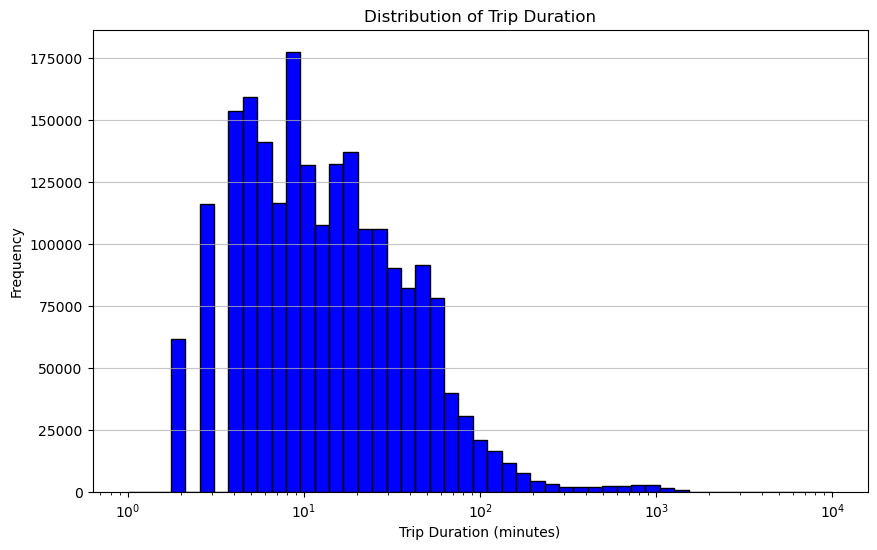

In [107]:
# Visualize the distrubution of trip duration
plt.figure(figsize=(10, 6))
plt.hist(df_trips['duration_minutes'], bins=np.logspace(0, 4, 50), color='blue', edgecolor='black')
plt.xscale('log')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Duration')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Data of trip duration goes from 2-34000 so 10^0 is 1min , 10^1 is 10mins and so on

In [18]:
# Identify the top start and end stations based on trip frequency.
start_station_freq = df_trips.groupby('start_station_name')['trip_id'].count().reset_index()

# drop values we do not need to analyze
start_station_freq.sort_values(by='trip_id',ascending=False,inplace = True)
start_station_freq.drop(start_station_freq.tail(10).index,inplace=True)
most_popular_start_stations = start_station_freq.head(10)


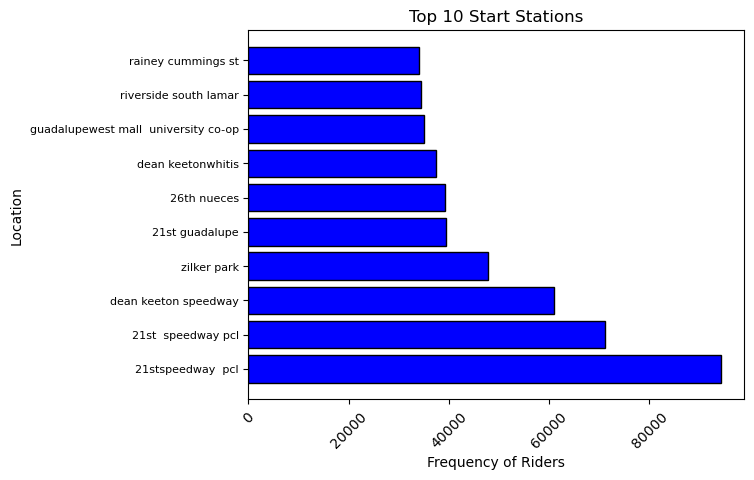

In [125]:
plt.barh(most_popular_start_stations['start_station_name'],most_popular_start_stations['trip_id'],color='blue',edgecolor='black')
plt.xticks(rotation=45, fontsize=10)
plt.yticks( fontsize=8)
plt.xlabel('Frequency of Riders')
plt.ylabel('Location')
plt.title('Top 10 Start Stations')
plt.show()

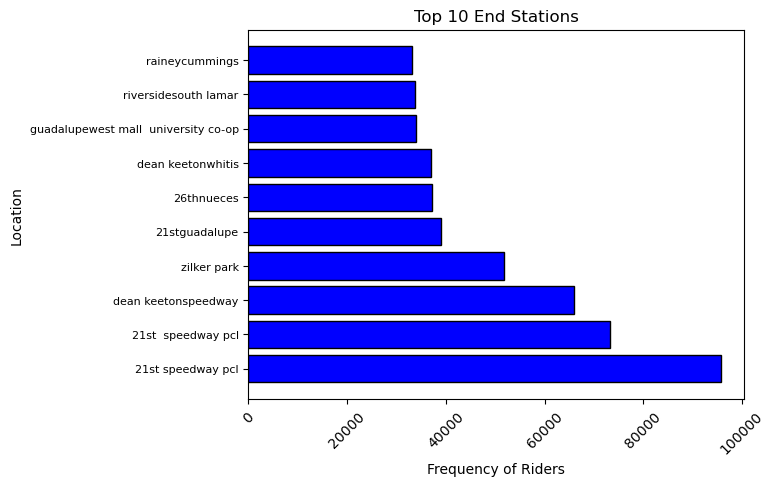

In [121]:
# Identify top end stations
end_station_freq = df_trips.groupby('end_station_name')['trip_id'].count().reset_index()

end_station_freq.sort_values(by='trip_id',ascending=False,inplace = True)
most_popular_end_stations = end_station_freq.head(10)

plt.barh(most_popular_end_stations['end_station_name'],most_popular_end_stations['trip_id'],color='blue',edgecolor='black')
plt.xticks(rotation=45, fontsize=10)
plt.yticks( fontsize=8)
plt.xlabel('Frequency of Riders')
plt.ylabel('Location')
plt.title('Top 10 End Stations')
plt.show()

In [127]:
# Explore subscriber types and their usage patterns.
avg_duration_subscriber = df_trips.groupby('subscriber_type')['duration_minutes'].mean().reset_index()
avg_duration_subscriber.sort_values(by='duration_minutes',ascending=False)
avg_duration_subscriber

,subscriber_type,duration_minutes
0,$1 Pay by Trip Fall Special,75.502146
1,$1 Pay by Trip Winter Special,72.757853
2,24 Hour Walk Up Pass,43.576219
3,24-Hour Membership,29.0
4,3-Day Explorer,34.623338
5,3-Day Weekender,34.473896
6,7-Day,14.741027
7,ACL 2019 Pass,31.869565
8,ACL Weekend Pass Special,21.147335
9,Aluminum Access,11.583333


## Advanced Analysis

In [71]:
# Visualize bike user trend over time (time series)
df_trips['date'] = pd.to_datetime(df_trips['date'])
year = df_trips['date'].dt.year
freq_over_time = df_trips.groupby(year)['trip_id'].count().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


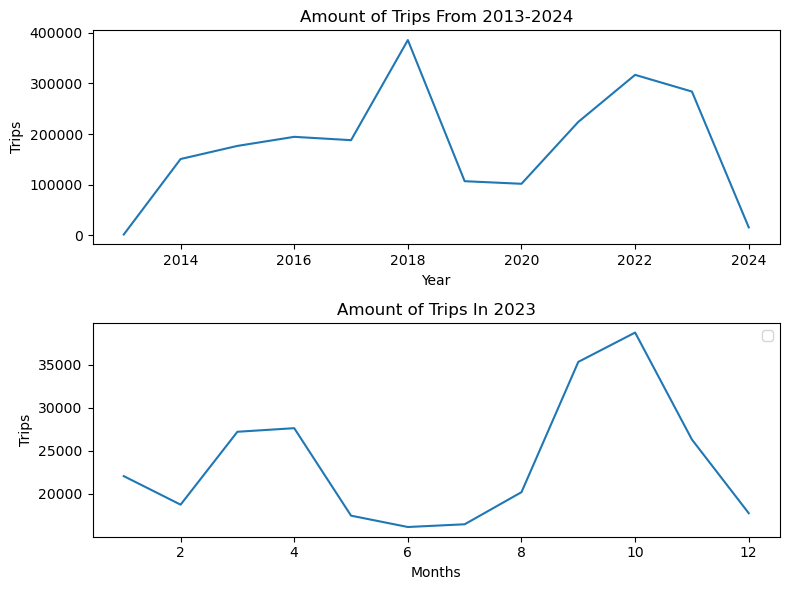

In [74]:
# bike trend over time for the months in 2023 and 2024 thus far
year = df_trips['date'].dt.year == 2023
year_data = df_trips[year]
# Extract the months from the date column for the specific year
months = year_data['date'].dt.month
m = df_trips.groupby(months)['trip_id'].count().reset_index()

# Create Subplots
fig, (ax1, ax2) = plt.subplots(2,figsize=(8, 6))

# Plot the first line chart on the first axes
ax1.plot(freq_over_time['date'], freq_over_time['trip_id'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Trips')
ax1.set_title('Amount of Trips From 2013-2024')

# Plot the second line chart on the second axes
ax2.plot(m['date'], m['trip_id'])
ax2.set_xlabel('Months')
ax2.set_ylabel('Trips')
ax2.set_title('Amount of Trips In 2023')
ax2.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()

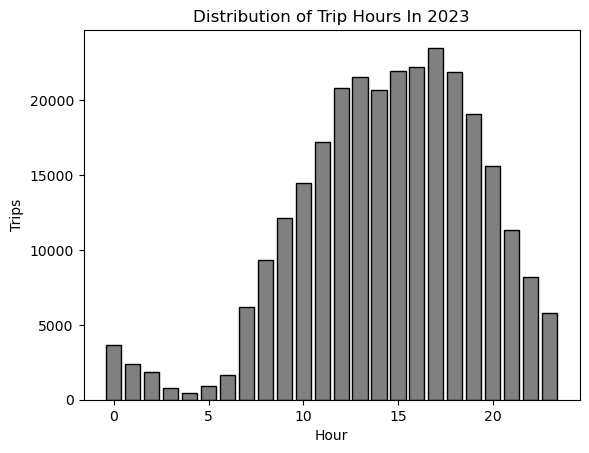

In [104]:
# Show peak Hours of Trips in 2023 
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'], format='%H:%M:%S')
year = df_trips['date'].dt.year == 2023
year_data = df_trips[year]
# Extract the months from the date column for the specific year
hours = year_data['start_time'].dt.hour
h = df_trips.groupby(hours)['trip_id'].count().reset_index()

h

plt.bar(h['start_time'],h['trip_id'],color='gray',edgecolor='black')
plt.xlabel("Hour")
plt.ylabel("Trips")
plt.title("Distribution of Trip Hours In 2023")
plt.show()
